In [ ]:
import { config } from "dotenv";
import { ChatBedrockConverse } from "@langchain/aws";
import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { StateGraph, MessagesAnnotation } from "@langchain/langgraph";
import { HumanMessage, AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { tool } from "@langchain/core/tools";


In [17]:
const env = config();

[dotenv@17.2.1] injecting env (0) from .env -- tip: ⚙️  load multiple .env files with { path: ['.env.local', '.env'] }


In [18]:
const timeTool = tool(async () => new Date().toISOString(), {
  name: "getCurentTime",
  description: "Returns the current date/time in ISO format",
});


In [19]:
const tools = [new TavilySearchResults({ maxResults: 3 }), timeTool];
const toolNode = new ToolNode(tools);

In [ ]:
const model = new ChatBedrockConverse({
  model: "us.amazon.nova-micro-v1:0",
  region: Deno.env.BEDROCK_AWS_REGION ?? "us-east-1",
  credentials: {
    secretAccessKey: Deno.env.BEDROCK_AWS_SECRET_ACCESS_KEY ?? "",
    accessKeyId: Deno.env.BEDROCK_AWS_ACCESS_KEY_ID ?? "",
  },
  temperature: 0,
}).bindTools(tools);


In [21]:
// Define the function that determine whether to continue or not
function shouldContinue({ messages }: typeof MessagesAnnotation.State) {
  const lastMessage = messages[messages.length - 1] as AIMessage;

  // If the LLM makes a tool call, then we route to the "tools" node
  if (lastMessage.tool_calls?.length) {
    return "tools";
  }
  // Otherwise, we stop (reply to the user) using the special "__end__" node
  return "__end__";
}

// Define the function that calls the model
async function callModel(state: typeof MessagesAnnotation.State) {
  const response = await model.invoke(state.messages);

  // We return a list, because this will get added to the existing list
  return { messages: [response] };
}

// Define a new graph
const workflow = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addEdge("__start__", "agent") // __start__ is a special name for the entrypoint
  .addNode("tools", toolNode)
  .addEdge("tools", "agent")
  .addConditionalEdges("agent", shouldContinue);


In [22]:
const app = workflow.compile();

In [23]:
const finalState = await app.invoke({
  messages: [new HumanMessage("what is the weather in sf")]
});

In [24]:
console.log(finalState.messages[finalState.messages.length - 1].content);

Based on the results I found, here is the current weather information for San Francisco:

- **Current Conditions:**
  - **Location:** San Francisco, California, United States of America
  - **Time:** 04:52 AM on July 26, 2025 (local time)
  - **Temperature:** 14.4°C (57.9°F)
  - **Weather:** Overcast
  - **Wind:** 9.4 mph (15.1 kph) from the WSW direction
  - **Humidity:** 87%
  - **Cloud Cover:** 100%
  - **Pressure:** 1016.0 mb

Please note that this information might be slightly outdated as it was found from the search results related to the weather in San Francisco. For the most current and precise weather updates, I recommend checking a reliable weather website or app directly.


In [25]:
const nextState = await app.invoke({
  messages: [...finalState.messages, new HumanMessage("what about ny")]
})

In [27]:
console.log(nextState.messages[nextState.messages.length - 1].content);


Based on the results I found, here is the current weather information for New York City:

- **Current Conditions:**
  - **Location:** New York City, New York, United States of America
  - **Time:** 07:52 AM on July 26, 2025 (local time)
  - **Temperature:** 25.3°C (77.5°F)
  - **Weather:** Sunny
  - **Wind:** 10.7 mph (17.3 kph) from the NE direction
  - **Humidity:** 58%
  - **Cloud Cover:** 0%
  - **Pressure:** 1020.0 mb
  - **UV Index:** 0.3 (Very Low)

Please note that the information is based on the search results related to the weather in New York City and may be slightly outdated. For the most current and precise weather updates, it is recommended to check a reliable weather website or app directly.


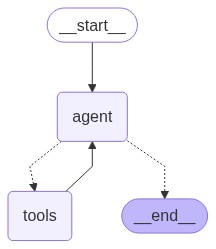

In [29]:
const graph = app.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

Deno.jupyter.image(new Uint8Array(arrayBuffer));